In [1]:
import math
import random
#Benötigte Pakete

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 
import seaborn as sns
from scipy import stats
from decimal import Decimal

import matplotlib.mlab as mlab

import cmath

from numpy import linalg as LA
import scipy
from scipy import spatial
import time
#import tables

import os
#import h5py

from matplotlib import animation
import matplotlib
from scipy.optimize import curve_fit
from matplotlib import rc

import gc
import sys
gc.enable()
import copy
from IPython.display import HTML
from mpl_toolkits import mplot3d

In [14]:
def quad_func(t,a):
    return a*t**2

def poly_func(t,a,c):
    return a*t**c

def lin_func(t,a):
    return a*t

In [2]:
from init_atoms import *

In [52]:
def generate_hamiltonian(atoms):
    number_atoms=len(atoms)
    
    #Distance + Hamiltonian-------------------------------------------------------------------------------------
    H = np.zeros((number_atoms,number_atoms),dtype=np.float16)
    global distance_matrix
    distance_matrix = np.zeros((number_atoms,number_atoms),dtype=np.float16)
    
    
    #start= time.time()
    distance_matrix= scipy.spatial.distance.cdist(atoms, atoms, metric='euclidean')
    np.fill_diagonal(distance_matrix,1)
    H=np.divide(coupling_constant,np.power(distance_matrix,3))
    np.fill_diagonal(distance_matrix,0)
    np.fill_diagonal(H,0)
    #print("Time for Hamiltonian: ",time.time()-start)
    
    
    global abstand_ursprung
    abstand_ursprung= np.zeros(number_atoms, dtype=np.float16)
    abstand_ursprung = copy.copy(distance_matrix[:,angeregt])
    
#Linearisierung---------------------------------------------------------------------------------------------
    #start = time.time()
    global eigenvalues
    eigenvalues=np.zeros(number_atoms,dtype=np.float16)
    global eigenvectors2
    eigenvectors=np.zeros((number_atoms,number_atoms),dtype=np.float16)
    eigenvalues, eigenvectors = LA.eigh(H)
    eigenvectors2=copy.copy(eigenvectors)
    #print("Time for Linearisierung: ",time.time()-start)
    
    
    #print(sys.getsizeof(H))
    H=None
    return eigenvalues, eigenvectors

In [4]:
def ultimate_justeins(eigen_values,eigenvectors,times_tmp,angeregt):
    
    total_steps=len(times_tmp)
#Zeitenwicklung--------------------------------------------------------------------------------------------
    #start = time.time()
    projection=eigenvectors[angeregt]
    psi_t= np.zeros((total_steps,number_atoms,1),dtype="complex64")
    for i,t in enumerate(times_tmp):
        psi_t[i]= (eigenvectors @ (np.exp(-1j*eigenvalues*t)*projection))[:,None]
        
    #print("Time for Probability_Zeitentwicklung: ",time.time()-start)
    
    #komplette Zeitenwicklung ohne Schleife, aber leider langsamer:
            #psi_t2= ((eigenvectors*np.exp(-1j*eigen_values*times_tmp[:,None])[:,None])@projection)[:,:,None]
    
    
#Wahrscheinlichkeiten---------------------------------------------------------------------------------------
    #start = time.time()
    np.square(np.absolute(psi_t,out=psi_t),out=psi_t)    # now psi_all_t = probability
    #print("Time for Probability_wahrscheinlichkeit: ",time.time()-start)

    probability=np.real(psi_t)
  
    psi_t = None
    gc.collect()
    
    
    return probability

In [43]:
def Berechnung(eigenvalues,eigenvectors,number_atoms,time_array):  
    
    probability = np.zeros((1,number_atoms,1))
    anzahl_steps_möglich =  math.floor(10000000000/(number_atoms*number_atoms))
    # Restriction for each PC for how many time steps it can handel
    
    global runden
    ang_anzahl_steps=round(len(time_array))
    runden = math.floor((ang_anzahl_steps-1)/anzahl_steps_möglich)
    print("Von ",time_array[0],"s bis",time_array[-1],"s mit", ang_anzahl_steps," steps")
    print("Maximal mögliche Anzahl an Steps auf einmal:",anzahl_steps_möglich )
    print("Anzahl Wiederholungen:",runden)
    
    start=time.time()

    for i in range(runden):
        times_tmp = time_array[i*anzahl_steps_möglich:(i+1)*anzahl_steps_möglich]
        print("round ", i, "  steps: ",len(times_tmp), " from: ",times_tmp[0], " to ", times_tmp[-1])
        
        prob_tmp = ultimate_justeins(eigenvalues,eigenvectors,times_tmp,angeregt)
        probability=np.append(probability,prob_tmp,axis=0)
    
    times_tmp = time_array[runden*anzahl_steps_möglich:]
    print("round ", runden, "  steps: ",len(times_tmp), " from: ",times_tmp[0], " to ", times_tmp[-1])
    prob_tmp = ultimate_justeins(eigenvalues,eigenvectors,times_tmp,angeregt)
    probability=np.append(probability,prob_tmp,axis=0)
        
    print("Berechnung:", np.round(time.time()-start,3))
       
       
    probability=np.delete(probability,0,axis=0)
                         
    return probability

In [19]:
def auswertung(probability):
     
    
    # Mean square und mean displacement---------------------------------------------------------------------
    r_2=np.dot(np.power(abstand_ursprung,2), probability)[:,0]
 
    #infinity_time-------------------------------------------------------------------------------------
    p_infinity=np.dot(np.square(eigenvectors[angeregt]),np.square(eigenvectors.transpose()))
    r_2_inf=np.dot(p_infinity,np.power(abstand_ursprung,2)[:,None])
    return r_2, r_2_inf

In [63]:
global number_atoms
global radius
coupling_constant= 3*10**9  #stärke der nachbarwechselwirkung
angeregt=0
#Parameter:
number_atoms=3000
density= 0.17
r_b = 5
radius = (np.sqrt(number_atoms*r_b**2/density))


time_array=np.logspace(-8,-3,100)


In [48]:
iterations=5

Von  1e-08 s bis 0.001 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1111
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.001
Berechnung: 7.705
Von  1e-08 s bis 0.001 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1111
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.001
Berechnung: 7.623
Von  1e-08 s bis 0.001 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1111
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.001
Berechnung: 7.619
Von  1e-08 s bis 0.001 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1111
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.001
Berechnung: 7.628
Von  1e-08 s bis 0.001 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1111
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.001
Berechnung: 7.618


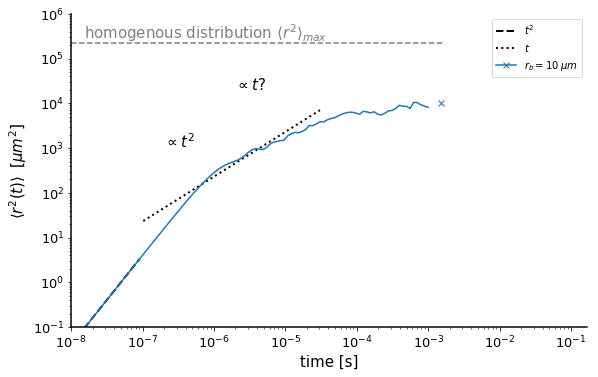

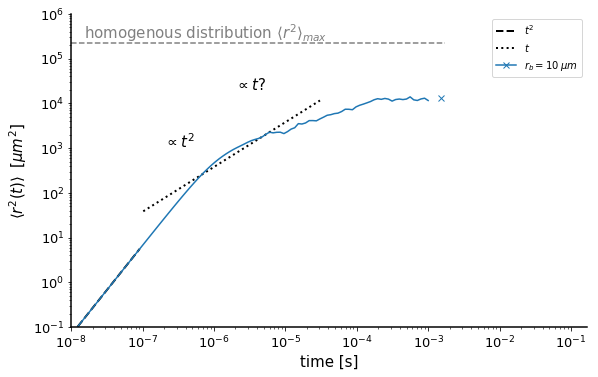

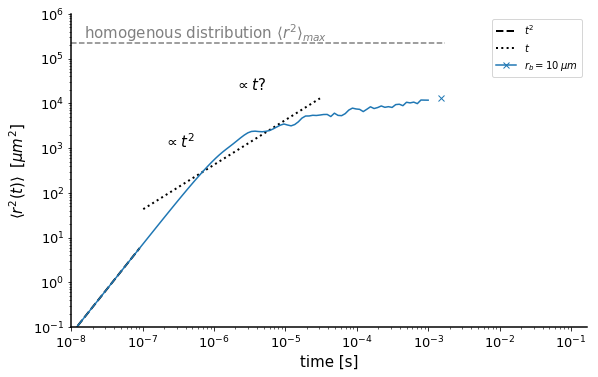

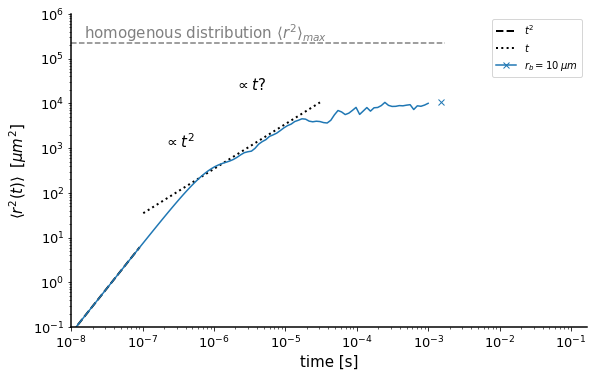

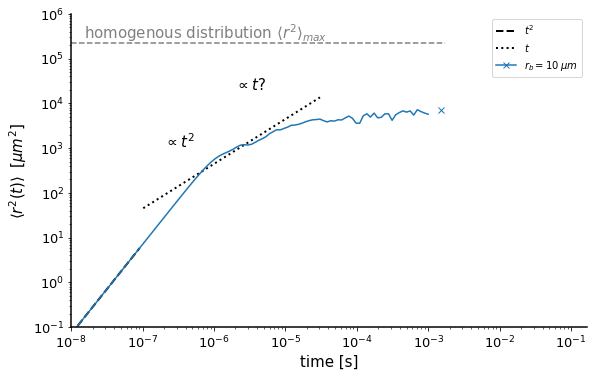

In [64]:
probability=np.zeros((iterations,len(time_array),number_atoms,1))
for i in range(iterations):
    atoms_array = produce_atoms(number_atoms, radius, r_b) 
    eigenvalues, eigenvectors = generate_hamiltonian(atoms_array)
    probability=Berechnung(eigenvalues,eigenvectors,number_atoms,time_array)
    plot_r2(probability)

In [54]:
def plot_r2(probability):
    plt.rc('xtick',labelsize=13)
    plt.rc('ytick',labelsize=13)


    from matplotlib import rc
    fig, axes = plt.subplots(1,1, figsize=(8,5))  
    plt.tight_layout()  
    axes.set_xscale("log")
    axes.set_yscale("log")
    plt.xlim(left=10**-8, right=1.7*10**-1)
    plt.ylim(0.1,10**6)


    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(1.5)


    r_2,r_2_inf  =auswertung(probability)


    popt1,pcov1 = curve_fit(quad_func,time_array[0:10],r_2[0:10],p0=[5*10**15])
    popt2,pcov2 = curve_fit(lin_func,time_array[30:40],r_2[30:40],p0=[5*10**15])
    plt.plot(time_array[0:20],quad_func(time_array[0:20],*popt1), label=r"$t^2$", color="black", linestyle = "--", linewidth=2);
    plt.plot(time_array[20:70],lin_func(time_array[20:70],*popt2), label=r"$t$", color="black", linestyle = ":", linewidth=2);



    axes.plot(time_array,r_2);
    axes.errorbar(time_array[-1]+time_array[-1]*0.5,r_2_inf, marker ="x", label=r"$r_b=10 \;\mu m$",color = "C0",capsize=2)



    axes.plot([10**-8,1.7*10**-3],[0.5*radius**2,0.5*radius**2],linestyle ="--", color= "grey")
    axes.text(1.5*10**-8,0.5*radius**2+50000,r"homogenous distribution $\langle r^2 \rangle_{max}$", color= "grey", fontsize=15)
    axes.text(2*10**-7,10**3,r"$\propto t^2$", fontsize=15)
    axes.text(2*10**-6,2*10**4,r"$\propto t ?$", fontsize=15)


    axes.set_xlabel("time [s]", fontsize=15)
    axes.set_ylabel(r"$\langle r^2(t) \rangle\;\;[\mu m^2]$", fontsize=15);
    axes.legend();

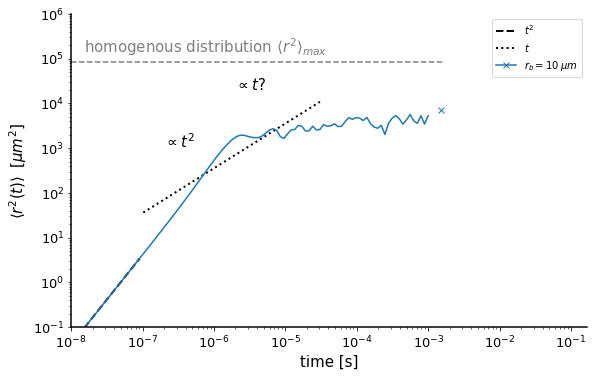

In [55]:
plot_r2(probability)